# Create data for intro track figure

In [1]:
import os
import sys
sys.path.append('../..')
from pykml import parser
import pandas as pd
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from bs4 import BeautifulSoup
import numpy as np
import xarray as xr
import cmocean
import cimf as c

plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams['font.cursive'] = ['Helvetica-Oblique']
plt.rcParams['pdf.fonttype'] = 42

In [2]:
# #===== Execute once =========

# # ==== Best track data ======
# best track data is downloaded from https://www.nhc.noaa.gov/data/
# unzip .kmz file to .kml

# # === Model track data ======
# ds = xr.open_mfdataset(
#     "/Users/jasperdejong/Documents/PhD/Irma/Data/LambertGrid/629x989interped/fc2017090512+0??.nc",
#     concat_dim="valid_time", combine="nested")
# ds['latc'] = ds.latitude.isel(x=ds.xc, y=ds.yc).compute()
# ds['lonc'] = ds.longitude.isel(x=ds.xc, y=ds.yc).compute()
# ds.latc.attrs.update({'long_name':'latitude of TC centre'})
# ds.lonc.attrs.update({'long_name':'longitude of TC centre'})
# ds.to_netcdf('modeltrack.nc')

# # === Model vmax data =======
# ds = xr.open_mfdataset(
#     "/Users/jasperdejong/Documents/PhD/Irma/Data/LambertGrid/629x989/fc2017090512+0??.nc",
#     concat_dim="valid_time", combine="nested")
# ds['latc'] = ds.latitude.isel(x=ds.xc, y=ds.yc).compute()
# ds['lonc'] = ds.longitude.isel(x=ds.xc, y=ds.yc).compute()
# ds.latc.attrs.update({'long_name':'latitude of TC centre'})
# ds.lonc.attrs.update({'long_name':'longitude of TC centre'})
# dsc = c.crop(ds, d=50)
# dsc = c.convert_wind(dsc)
# dsc['V'] = np.sqrt(dsc.u**2 + dsc.v**2)
# dsc['V10'] = np.sqrt(dsc.u10**2 + dsc.v10**2)
# dsc['V10gst'] = np.sqrt(dsc.u10gst**2 + dsc.v10gst**2)
# dsc.V.attrs.update({'long_name':'max wind speed'})
# dsc.V10.attrs.update({'long_name':'max 10m wind speed'})
# dsc.V10gst.attrs.update({'long_name':'max 10m gusts'})
# dsc = dsc[['u','v','u10','v10','u10gst','v10gst','u_rad','v_tan','V','V10','V10gst']]
# dsmax = np.abs(dsc).max(dim=('dy','dx'),keep_attrs=True)
# dsmax.to_netcdf('modelwindmax.nc')

#### Read kml file

In [3]:
filename='al112017.kml'

with open(filename) as f:
    Placemarks = parser.parse(f).getroot().Document.Folder.Placemark
    
times = [pd.to_datetime(str(e.name),format="%H%M UTC %b %d %Y") 
         for e in Placemarks]
coords = [str(e.Point.coordinates).split(',') for e in Placemarks]
lons, lats, _ = np.array(coords, dtype='float64').T
DATA = [BeautifulSoup(e.description.text).body.text.split("\n\n\n")[3:-2] for e in Placemarks]
cols = [row.split('\n')[0] for row in DATA[0]]
data = [[row.split('\n')[1] for row in ROW] for ROW in DATA]
df = pd.DataFrame(data, index=times, columns=cols)
df['LATITUDE'] = lats
df['LONGITUDE'] = lons
df.index.name = 'TIME'
for var in ['TAU','MSLP','INTENSITY','SS','LAT','LON','LATITUDE','LONGITUDE']:
    df[var] = df[var].astype('float64')
df

,STORMNAME,DTG,YEAR,MONTH,DAY,HHMM,TAU,MSLP,BASIN,STORMNUM,STORMTYPE,INTENSITY,SS,LAT,LON,LATITUDE,LONGITUDE
TIME,,,,,,,,,,,,,,,,,
2017-08-30 00:00:00,INVEST,2017083000,2017,AUG,30,0000,0.0,1008.0,AL,11,Tropical Depression,30.0,0.0,16.1,-26.9,16.100000,-26.900000
2017-08-30 06:00:00,INVEST,2017083006,2017,AUG,30,0600,0.0,1007.0,AL,11,Tropical Storm,35.0,0.0,16.2,-28.3,16.200001,-28.299999
2017-08-30 12:00:00,IRMA,2017083012,2017,AUG,30,1200,0.0,1006.0,AL,11,Tropical Storm,45.0,0.0,16.3,-29.7,16.299999,-29.700001
2017-08-30 18:00:00,IRMA,2017083018,2017,AUG,30,1800,0.0,1004.0,AL,11,Tropical Storm,50.0,0.0,16.3,-30.8,16.299999,-30.799999
2017-08-31 00:00:00,IRMA,2017083100,2017,AUG,31,0000,0.0,999.0,AL,11,Tropical Storm,55.0,0.0,16.3,-31.7,16.299999,-31.700001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-12 12:00:00,IRMA,2017091212,2017,SEP,12,1200,0.0,1000.0,AL,11,Low,20.0,0.0,33.8,-86.9,33.799999,-86.900002
2017-09-12 18:00:00,IRMA,2017091218,2017,SEP,12,1800,0.0,1003.0,AL,11,Low,15.0,0.0,34.8,-88.1,34.799999,-88.099998
2017-09-13 00:00:00,IRMA,2017091300,2017,SEP,13,0000,0.0,1004.0,AL,11,Low,15.0,0.0,35.6,-88.9,35.599998,-88.900002


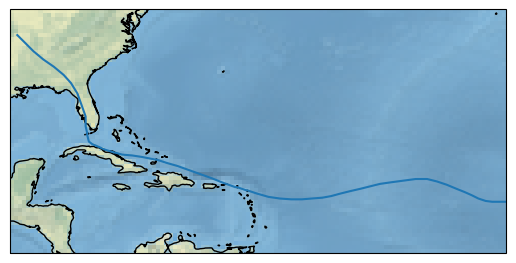

In [4]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.plot(df.LONGITUDE[0:],df.LATITUDE[0:])
ax.coastlines()
ax.stock_img()
ax.set_extent([-91, -30, 10, 40], crs=ccrs.PlateCarree())

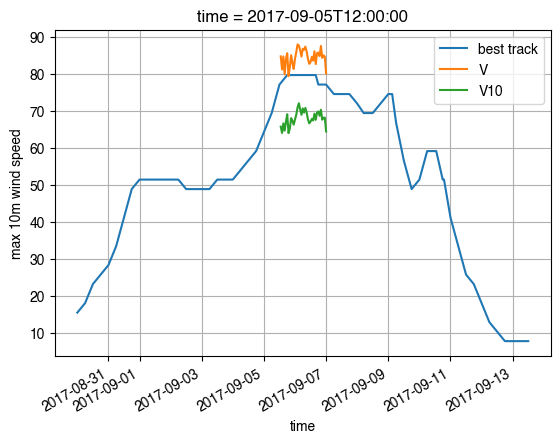

In [5]:
kt2ms = 0.51444444 # knots to m/s
dsmax = xr.open_dataset('modelwindmax.nc')
(df.INTENSITY*kt2ms).plot(label='best track')
dsmax.V[1:].max('hybrid').plot(label='V')
dsmax.V10[1:].plot(label='V10')
plt.legend()
plt.grid()

In [6]:
dst = xr.open_dataset("modeltrack.nc")

In [7]:
ds = xr.open_dataset("fc2017090512+000-036grib_rain",filter_by_keys={'stepType': 'instant'}, engine='cfgrib')

In [8]:
dst.xc.data, dst.yc.data

(array([535, 527, 521, 515, 506, 500, 494, 486, 480, 474, 467, 461, 454,
        448, 439, 430, 422, 414, 406, 399, 391, 385, 378, 370, 363, 354,
        345, 336, 329, 322, 314, 306, 300, 293, 285, 276, 267]),
 array([366, 367, 368, 371, 372, 374, 377, 379, 380, 383, 385, 385, 387,
        390, 394, 396, 398, 400, 403, 406, 409, 413, 416, 420, 424, 428,
        433, 436, 438, 443, 447, 451, 455, 459, 464, 467, 470]))

In [9]:
topo = xr.open_dataset('ETOPO2v2c_f4.nc')
topos = topo.sel(x=slice(-95,-20),y=slice(0,45))

Text(0.5, 1.0, 'Rain and track')

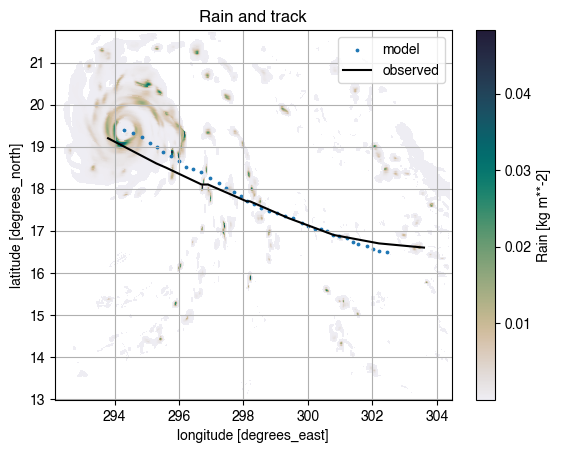

In [10]:
dss = ds.isel(step=36,x=range(200,600),y=range(250,550))
p = dss.rain.where(dss.rain>0,np.nan).plot(x='longitude',y='latitude',cmap=cmocean.cm.rain)
p.axes.scatter(dst.lonc, dst.latc, s=3, label='model')
p.axes.plot(df.LONGITUDE[25:36]+360,df.LATITUDE[25:36],'k', label='observed')
p.axes.legend()
p.axes.grid()
p.axes.set_title("Rain and track")

In [11]:
def intensity_scale(vmax=None):
    """Color scale based on maximum wind"""
    if vmax is None:
        colors = ['#6EC1EA','#4DFFFF','#FFFFD9','#FFD98C','#FF9E59','#FF738A','#a188fc']
        labels = ['TD','TS','CAT 1','CAT 2','CAT 3', 'CAT 4', 'CAT 5']
        return colors, labels
    if vmax < 34:                    # TD
        return '#6EC1EA'
    elif vmax >= 34 and vmax < 64:   # TS
        return '#4DFFFF'
    elif vmax >= 64 and vmax < 83:   # CAT 1
        return '#FFFFD9'
    elif vmax >= 83 and vmax < 96:   # CAT 2
        return '#FFD98C'
    elif vmax >= 96 and vmax < 113:  # CAT 3 / Major Hurricane
        return '#FF9E59'
    elif vmax >= 113 and vmax < 137: # CAT 4
        return '#FF738A'
    elif vmax >= 137:                # CAT 5
        return '#a188fc'
    else:
        print('no color for vmax =',vmax)
        return None

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


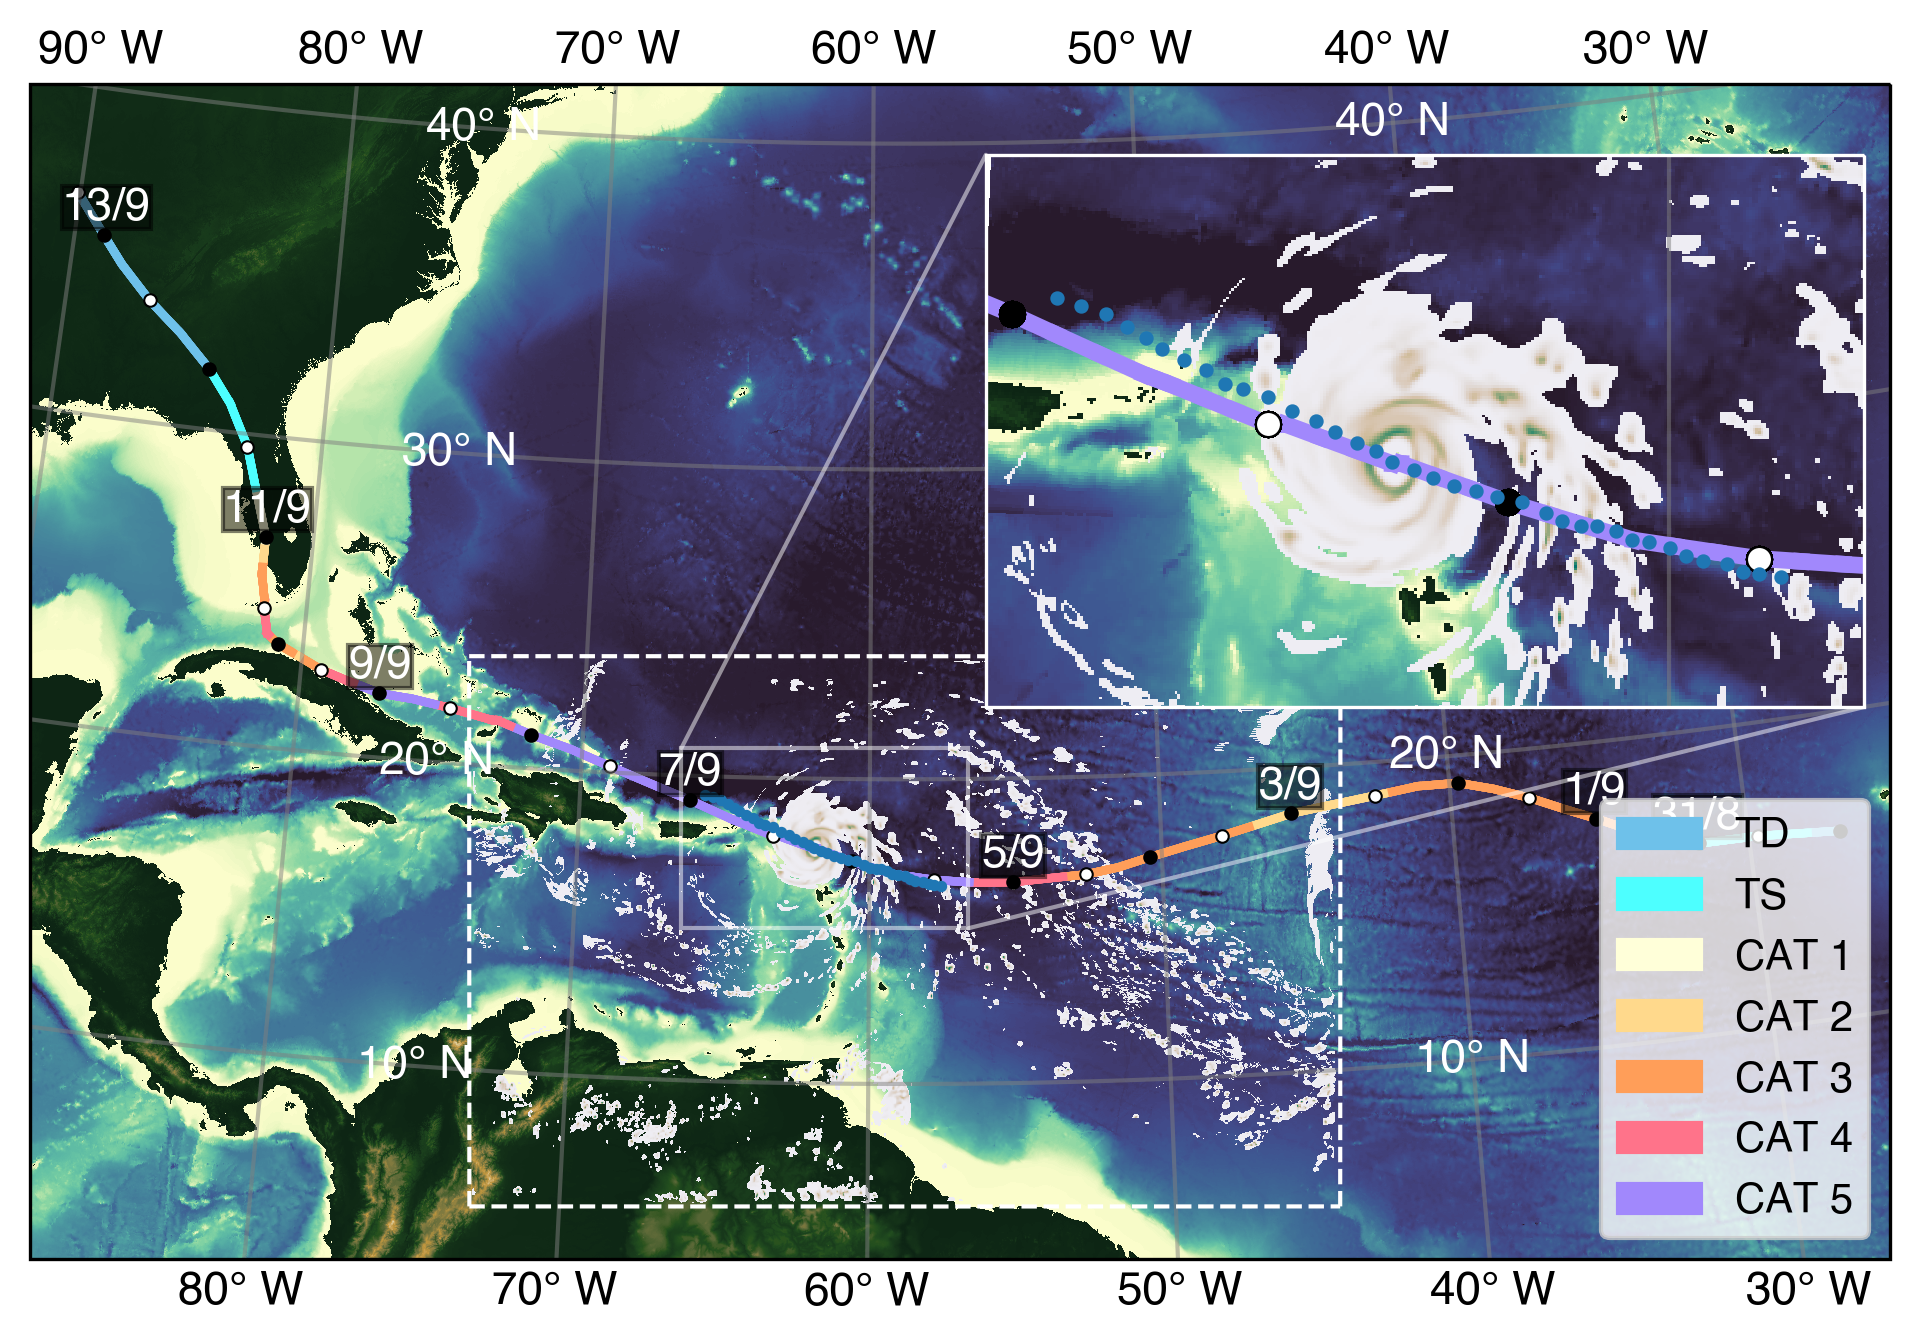

In [34]:
# FuncFormatter can be used as a decorator
@mticker.FuncFormatter
def lon_formatter(x, pos):
    return f"{abs(x):.0f}° W" if x<0 else f"{x:.0f}° E"
@mticker.FuncFormatter
def lat_formatter(x, pos):
    return f"{abs(x):.0f}° S" if x<0 else f"{x:.0f}° N"


rain_step = 20
#best_track_lw = 2
#best_track_s = 3
#mew = 0.5 # marker edge width
track_props = {'ls':'','lw':2, 'ms':3, 'color':'k','marker':'o','mew':0.5,'transform':ccrs.PlateCarree(),'zorder':2}
track_props2 = {k:track_props[k] for k in ['lw','transform','zorder']}
track_propsi = {'ls':'','lw':4, 'ms':6, 'color':'k','marker':'o','mew':0.5,'transform':ccrs.PlateCarree(),'zorder':2}
track_propsi2 = {k:track_propsi[k] for k in ['lw','transform','zorder']}
domain_props = {'color':'w','lw':1,'ls':'--','zorder':4,'transform':ccrs.PlateCarree()}
#domain_color = 'k'
#domain_lw = 1

labelsize = 11
ds1 = ds.isel(step=rain_step)

fig = plt.figure(figsize=(8,7), dpi=300)
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-58.8, central_latitude=15,standard_parallels=(15,15)))
ax.set_extent([-87, -27, 4, 40], crs=ccrs.PlateCarree())

# Background topography
ptopo = ax.pcolormesh(topos.x,topos.y,topos.z, transform=ccrs.PlateCarree(), cmap=cmocean.cm.topo,
              norm=mcolors.CenteredNorm(halfrange=6000),zorder=0, rasterized=True)

# Track
ids00 = (df.index.hour == 0)
ids12 = (df.index.hour == 12)
for i in range(1,len(df)):
    month,day = df.index[i].month, df.index[i].day
    if (day%2==1) and df.index[i].hour==0:
        ax.text(df.LONGITUDE[i],df.LATITUDE[i]+0.5,f'{day}/{month}',
                fontdict={'fontsize':labelsize, 'ha':'center', 'color':'white'}, 
                transform=ccrs.PlateCarree(), zorder=4, bbox=dict(facecolor='k', alpha=0.5, pad=0.05))
    lons = np.linspace(df.LONGITUDE[i-1],df.LONGITUDE[i],24)
    lats = np.linspace(df.LATITUDE[i-1],df.LATITUDE[i],24)
    vmax = np.linspace(df.INTENSITY[i-1],df.INTENSITY[i],24)
    colors = list(map(intensity_scale,(vmax[1:]+vmax[:-1])/2))
    for ii in range(1,len(lons)):
        #ax.plot((lons[ii-1],lons[ii]),(lats[ii-1],lats[ii]), lw=best_track_lw, color=colors[ii-1], transform=ccrs.PlateCarree())
        ax.plot((lons[ii-1],lons[ii]),(lats[ii-1],lats[ii]), color=colors[ii-1], **track_props2)
p00 = ax.plot(df.LONGITUDE[ids00], df.LATITUDE[ids00], mfc='k', **track_props)
p12 = ax.plot(df.LONGITUDE[ids12], df.LATITUDE[ids12], mfc='w', **track_props)
#ax.plot(df.LONGITUDE[:],df.LATITUDE[:], lw=best_track_lw, color=list(map(intensity_scale,df.INTENSITY)), transform=ccrs.PlateCarree())
ax.scatter(dst.lonc, dst.latc, s=3, transform=ccrs.PlateCarree(), label='model', zorder=3)

# Rain and domain
ax.pcolormesh(ds1.longitude, ds1.latitude, ds1.rain.where(ds1.rain>0,np.nan), transform=ccrs.PlateCarree(), cmap=cmocean.cm.rain, zorder=1, rasterized=True)
ax.plot(ds.longitude[0,:], ds.latitude[0,:], **domain_props)
ax.plot(ds.longitude[-1,:], ds.latitude[-1,:], **domain_props)
ax.plot(ds.longitude[:,0], ds.latitude[:,0], **domain_props)
ax.plot(ds.longitude[:,-1], ds.latitude[:,-1], **domain_props)

# Grid lines
gl = ax.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True, xformatter=lon_formatter, yformatter=lat_formatter, xlocs=np.arange(-90,-19,10), ylocs=np.arange(10,41,10),
    xlabel_style={'size':labelsize,'rotation':0,'ha':'center'}, ylabel_style={'size':labelsize,'color':'white'}, xpadding=8, ypadding=5, 
    linewidth=1, color='gray', alpha=0.5, linestyle='-',x_inline=False, y_inline=True, dms=False)
#ax.xaxis.set_major_formatter(lon_formatter)
#ax.yaxis.set_major_formatter(LatitudeFormatter)

# Legend
track_colors, track_labels = intensity_scale()
track_handles = [mpatches.Patch(color=c, label=l) for (c,l) in zip(track_colors, track_labels)]
ax.legend(handles=track_handles, loc='lower right')

# Create inset axes
x1, x2, y1, y2 = 293.5, 303.5, 15, 21 # zoom in region
axins = ax.inset_axes([0.5,0.47,0.5,0.47], projection=ax.projection)
axins.spines[:].set_color('white')
axins.set_extent([x1+0.15,x2-0.15,y1+0.1,y2-0.1], crs=ccrs.PlateCarree())
ax.indicate_inset_zoom(axins, edgecolor="white")

# Rain
pirain = axins.pcolormesh(ds1.longitude, ds1.latitude, ds1.rain.where(ds1.rain>0,np.nan), cmap=cmocean.cm.rain, transform=ccrs.PlateCarree(), zorder=1, rasterized=True)

# Grid lines
axins.axhline(20,lw=1,color='gray',alpha=0.5,linestyle='-',zorder=1)
axins.axvline(-60,lw=1,color='gray',alpha=0.5,linestyle='-',zorder=1)

# Track
axins.scatter(dst.lonc, dst.latc, s=6, transform=ccrs.PlateCarree(), label='model', zorder=3)
for i in range(1,len(df)):
    lons = np.linspace(df.LONGITUDE[i-1],df.LONGITUDE[i],4)
    lats = np.linspace(df.LATITUDE[i-1],df.LATITUDE[i],4)
    vmax = np.linspace(df.INTENSITY[i-1],df.INTENSITY[i],4)
    colors = list(map(intensity_scale,(vmax[1:]+vmax[:-1])/2))
    for ii in range(1,len(lons)):
        axins.plot((lons[ii-1],lons[ii]),(lats[ii-1],lats[ii]), color=colors[ii-1], **track_propsi2)
    axins.plot(df.LONGITUDE[ids00], df.LATITUDE[ids00], mfc='k', **track_propsi, label='00Z')
    axins.plot(df.LONGITUDE[ids12], df.LATITUDE[ids12], mfc='w', **track_propsi, label='12Z')
    #axins.set_xticklabels([])
#axins.set_yticklabels([])
toposs = topos.sel(x=slice(x1-360,x2-360),y=slice(y1,y2))
axins.pcolormesh(toposs.x,toposs.y,toposs.z, transform=ccrs.PlateCarree(), cmap=cmocean.cm.topo,
              norm=mcolors.CenteredNorm(halfrange=6000),zorder=0, rasterized=True)
#axins.legend(loc='left')


#fig.tight_layout()
fig.savefig('track.pdf', format='pdf', bbox_inches='tight', dpi=300, transparent=False)

#plt.colorbar(ptopo, ax=ax, location='bottom', shrink=0.5)

(<matplotlib.patches.Rectangle at 0x7fa99cf52850>,
 (<matplotlib.patches.ConnectionPatch at 0x7fa99d314520>,
  <matplotlib.patches.ConnectionPatch at 0x7fa99d314970>))

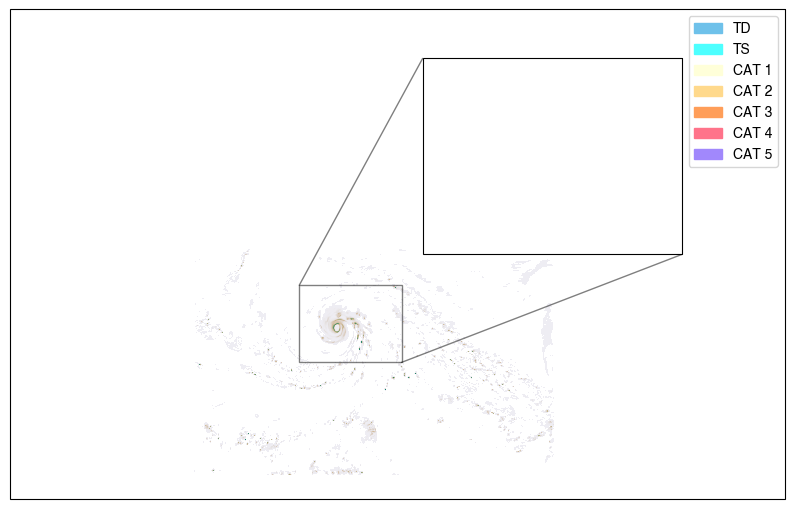

In [13]:
rain_step = 20
best_track_lw = 2
best_track_s = 3
mew = 0.5 # marker edge width
domain_color = 'k'
domain_lw = 1
labelsize = 11
ds1 = ds.isel(step=rain_step)
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-58.8, central_latitude=15,standard_parallels=(15,15)))
track_colors, track_labels = intensity_scale()
track_handles = [mpatches.Patch(color=c, label=l) for (c,l) in zip(track_colors, track_labels)]
ax.legend(handles=track_handles, loc='upper right')

Z = topos.z.copy()
X, Y = np.meshgrid(Z.x,Z.y)
topocmap = cmocean.tools.lighten(cmocean.cm.topo, 1)
#p = ax.pcolormesh(X, Y, Z, norm=colors.CenteredNorm(0,6000), cmap=topocmap, zorder=0, transform=ccrs.PlateCarree(),rasterized=True)
p2 = ax.pcolormesh(ds1.longitude, ds1.latitude, ds1.rain.where(ds1.rain>0,np.nan), transform=ccrs.PlateCarree(), cmap=cmocean.cm.rain, zorder=1)
ax.set_extent([-87, -27, 4, 40], crs=ccrs.PlateCarree())

axins = ax.inset_axes([0.5,0.5,0.4,0.4], projection=ax.projection)
axins.set_extent([x1+0.1,x2-0.1,y1,y2], crs=ccrs.PlateCarree())
ax.indicate_inset_zoom(axins, edgecolor="black")

In [54]:
fig = plt.figure(figsize=(10,20))

fig.savefig('test.pdf',format='pdf',dpi=300,backend='pdf')
plt.tight_layout()
plt.show()

/var/folders/x5/29t2fzws2dn4xtmh2gmjdgwr0000gp/T/ipykernel_96865/1434664501.py:5: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


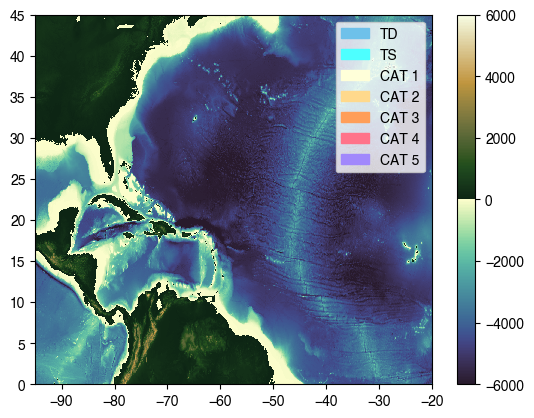

In [14]:
#axx = plt.axes(projection=ccrs.LambertConformal(central_longitude=-58.8, central_latitude=15,standard_parallels=(15,15)))
#axx.set_extent([-87, -27, 4, 40], crs=ccrs.PlateCarree())
axx = plt.axes()
#axx.legend(handles=track_handles)
p = axx.pcolormesh(X, Y, Z, norm=mcolors.CenteredNorm(0,6000), cmap=topocmap, zorder=0,rasterized=True)
#p2 = axx.pcolormesh(ds1.longitude, ds1.latitude, ds1.rain.where(ds1.rain>0,np.nan), transform=ccrs.PlateCarree(), cmap=cmocean.cm.rain, zorder=1)
#ph = axx.axhline(10, label='hline')
plt.colorbar(p)
axx.legend(handles=track_handles)
